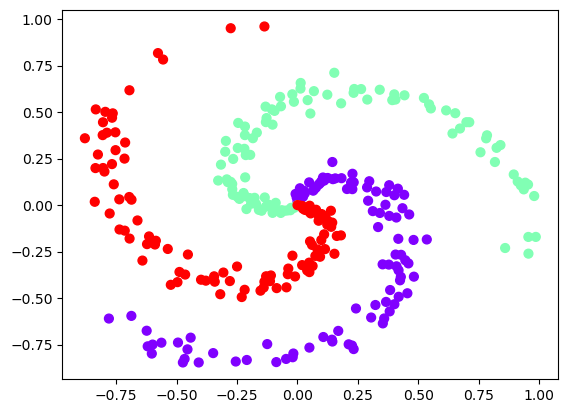

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='rainbow')
plt.show()

In [2]:
# Create a train/test split
import torch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Convert to torch tensors
X_train = torch.from_numpy(X_train).type(torch.float32)
X_test = torch.from_numpy(X_test).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [3]:
# Define the model

class SpiralModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        self.linear_layer_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
        )
        
    def forward(self, x):
        return self.linear_layer_model(x)
    
ModelV1= SpiralModel(2,3,100)
ModelV1

SpiralModel(
  (linear_layer_model): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [4]:
# Create a loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ModelV1.parameters(), lr=0.001)

In [5]:
# Create metrics for measuring performance (F1 score)

# Create device agnostic code
from torchmetrics.classification import MulticlassF1Score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
ModelV1 = ModelV1.to(device)

F1_score = MulticlassF1Score(num_classes=3, average='macro').to(device)



In [6]:
# Create a training and testing loop

from ast import Mod
import torch


epochs = 1000

for epoch in range(epochs):
    ######## Training ##########
    ModelV1.train()
    # Forward pass
    y_logits = ModelV1(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    # Calculate loss & F1 score
    loss = loss_fn(y_logits, y_train)
    train_F1 = F1_score(y_pred, y_train)
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    optimizer.step()
    
    ######## Testing ##########
    ModelV1.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = ModelV1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        # Calculate loss & F1 score
        test_loss = loss_fn(test_logits, y_test)
        test_F1 = F1_score(y_pred, y_train)
        
    
    # Print the loss and F1 score
    if epoch % 100 == 0:
        print(f"""
            Epoch: {epoch}
            Training loss: {loss:.4f}
            Training F1 score: {train_F1:.4f}
            --------------------------------
            Testing loss: {test_loss:.4f}
            Testing F1 score: {test_F1:.4f}
            """)


            Epoch: 0
            Training loss: 1.1271
            Training F1 score: 0.1616
            --------------------------------
            Testing loss: 1.1051
            Testing F1 score: 0.1616
            

            Epoch: 100
            Training loss: 0.6635
            Training F1 score: 0.5949
            --------------------------------
            Testing loss: 0.7611
            Testing F1 score: 0.5949
            

            Epoch: 200
            Training loss: 0.4661
            Training F1 score: 0.7811
            --------------------------------
            Testing loss: 0.5331
            Testing F1 score: 0.7811
            

            Epoch: 300
            Training loss: 0.2605
            Training F1 score: 0.9063
            --------------------------------
            Testing loss: 0.2906
            Testing F1 score: 0.9063
            

            Epoch: 400
            Training loss: 0.1540
            Training F1 score: 0.9600
          

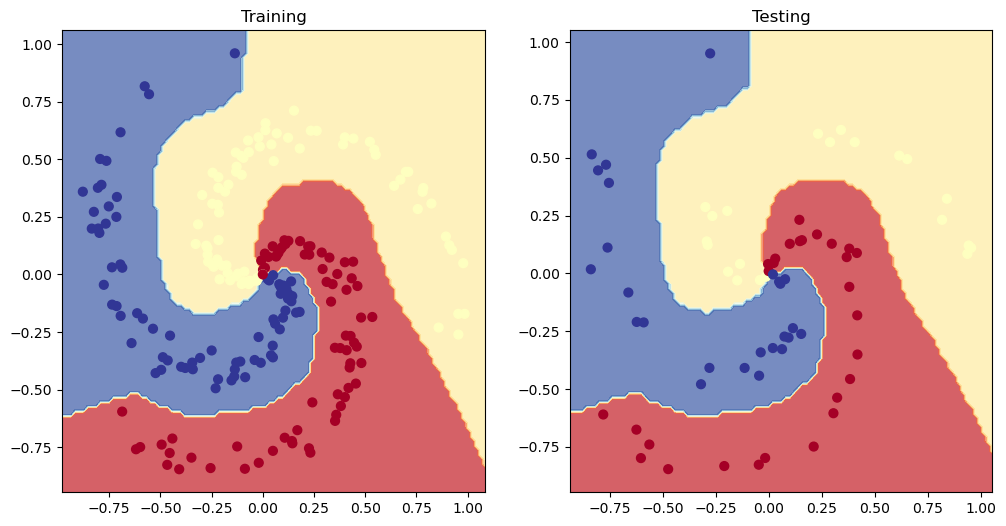

In [7]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training")

plot_decision_boundary(ModelV1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(ModelV1, X_test, y_test)